In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
plt.style.use('ggplot')
seaborn.set_context('talk')

In [49]:
t=pd.read_excel('sequencing_costs_table_july_2017.xls').set_index('Date')['Cost per Genome']

In [44]:
#t=t.asfreq('1M').rolling(7,min_periods=0,center=True,win_type='triang').mean()

In [52]:
t=t.asfreq('1M').interpolate('pchip')

Text(0, 0.5, 'Cost of sequencing a genome ($)')

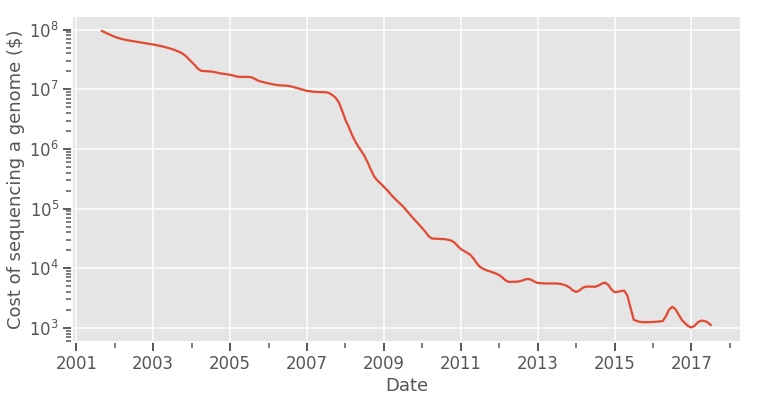

In [53]:
t.plot(figsize=(12,6))
plt.yscale('log')
plt.ylabel('Cost of sequencing a genome ($)')


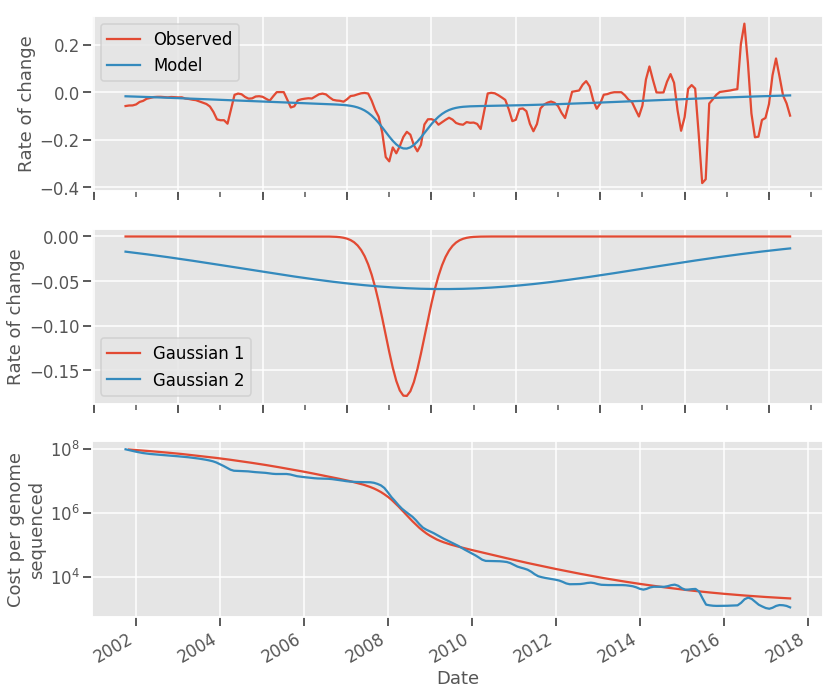

In [232]:
def gauss(x, A, mu, sigma):

    return A * np.exp(-(x - mu) ** 2 / 2 / sigma ** 2)


def bimodal(x, mu1, mu2, A1, A2, sigma1, sigma2):

    return gauss(x, A1, mu1, sigma1) + gauss(x, A2, mu2, sigma2) + 0


from scipy.optimize import curve_fit

this = t.reset_index(drop=True).pct_change().dropna()

to_fit = this.copy()
coef, _ = curve_fit(
    bimodal,
    to_fit.index.values.squeeze(),
    to_fit.values.squeeze(),
    maxfev=10000000,
    p0=[10, 170, -1, -1, 200, 200],
    bounds=[(0, 0, -10, -10, 0, 0), (175, 175, 0, 0, 100000, 100000)],
)
plt.figure(figsize=(12, 10))
ax = plt.subplot(3, 1, 1)
this.index = t.index[1:]
this.plot()
k = pd.DataFrame({"Model": bimodal(to_fit.index, *coef)}).set_index(t.index[1:])
k.plot(ax=plt.gca())

plt.legend(["Observed", "Model"])
plt.ylabel("Rate of change")
plt.subplot(3, 1, 2, sharex=ax)
k = pd.DataFrame(
    {
        "Gaussian 1": gauss(to_fit.index, coef[2], coef[0], coef[4]),
        "Gaussian 2": gauss(to_fit.index, coef[3], coef[1], coef[5]),
    }
).set_index(t.index[1:])
k.plot(ax=plt.gca())
plt.ylabel("Rate of change")


plt.subplot(3, 1, 3)

plt.plot(t.index[1:],np.cumprod((bimodal(to_fit.index, *coef)+1))*t[0])
t.pipe(lambda x: x).plot()
plt.yscale('log')
plt.yscale("log")
plt.ylabel("Cost per genome\nsequenced")

plt.tight_layout()
plt.savefig('sumgaus.png')

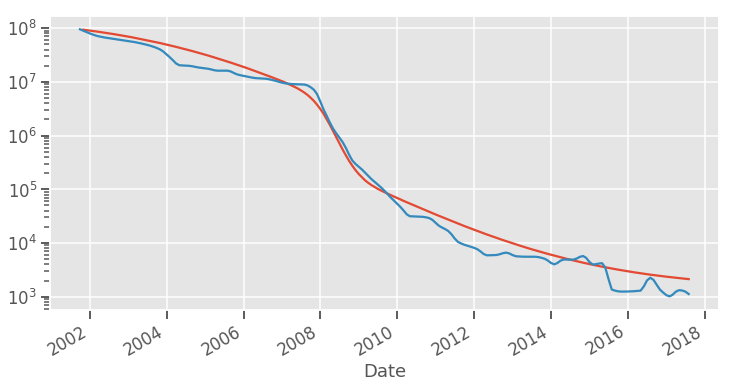

In [230]:
plt.figure(figsize=(12,6))
plt.plot(t.index[1:],np.cumprod((bimodal(to_fit.index, *coef)+1))*t[0])
t.pipe(lambda x: x).plot()
plt.yscale('log')

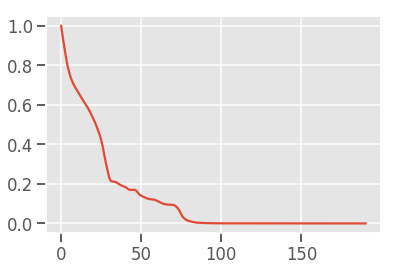

In [164]:
t.reset_index(drop=True).pipe(lambda x: x/x[0]).plot()